# Shapley values

Está basado en la teoria de juegos. Tenemos a varios jugadores jugando en equipo, queremos saber cuanto influye cada uno de los jugadores en el resultado del juego. 
Para ver la contribución de cada jugador en el resultado se calcula:

- Todas las combinaciones posibles de jugadores que incluyan a ese jugador. 
    - Para cada combinación (x') se calcula:
        - El resultado obtenido en el juego con esa combinación ($Y_{con}$)
        - El resultado obtenido en el juego con esa combinación, al excluir al jugador a estudiar ($Y_{sin}$)
        - Valor marginal = $Y_{con} - Y_{sin}$

El shap value de ese jugador es la media de todos los valores marginales calculados.

Se calculan todas las posibles combinaciones porque el jugador A puede jugar mejor si está con B, por lo tango hay que hacer una media de su aportación para saber lo que aporta independientemente de con quien esté jugando

En este ejemplo los jugadores serían variables, el juego sería el modelo y el resultado sería el output del modelo.

### e.g. Shapley de A


Combinaciones posibles con sus resultados

- A,B,C -> $Y_{ABC}$
- A,B -> $Y_{AB}$
- A,C -> $Y_{AC}$
- A -> $Y_{A}$

Valores marginales

- $marginal_{ABC} = Y_{ABC} - Y_{BC}$
- $marginal_{AB} = Y_{AB} - Y_{B}$
- $marginal_{AC} = Y_{AC} - Y_{C}$
- $marginal_{A} = Y_{A} - Y$

$$\phi_A(modelo, row) = \frac {marginal_{ABC}+marginal_{AB}+marginal_{AC}+marginal_{A}}4$$

<div style="text-align: center"> El shapley value para A, para ese modelo, para esa row (muestra) será la media de los valores marginales</div>

<div style="text-align: center">  Realmente no es una media exacta es ponderada, la formula se ve a continuación </div>

## Formula

$$\phi_{i}(f,x) = \sum_{z' ⊆ x'} \frac{\lvert z'\lvert !  (M- \lvert z' \lvert -1)!}{M!} [f_{x}(z') - f_{x}(z'/i)]$$

- $\phi_{i}$: shapley value of i para el modelo f en la muestra x
- f: model
- x: data input (row), (e.g. Age = 56, Gender = F, BMI = 30, HR = 80)
- z': subset
- x': simplified data input (row), (e.g. Age = 56, Gender = NA, BMI = NA, HR = 80)
- M: n features incluidas
- $f_{x}(z')$: resultados con todo z'
- $f_{x}(z'/i)$: resultados con todo z' menos la feature a estudiar
- Contribución de la variable (valor marginal): $[f_{x}(z') - f_{x}(z'/i)]$
- Peso de la contribución: $\frac{\lvert z'\lvert !  (M- \lvert z' \lvert -1)!}{M!}$

Para calcular el shapley value de i se calculan todos los x' posibles (subset of a set = $2^n$), se calcula el *valor marginal* para cada x' y se ponderan todos los valores marginales segun *peso de la contribución*

Si  $f_{x}(Age = 56, HR = 80) = 0.7$  y $f_{x}(HR = 80) = 0.1$, entonces Age contribuye un 0.6

 # SHAP kernel

In [48]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression

## Modelo de regresión logística

Vamos a construir un modelo que predice el riesgo de ictus en funcion de cuatro variables

In [95]:
df = {'Age': [56, 72, 56, 40, 25, 60, 38], 
      'Gender_F': [1, 0, 0, 1, 1, 0, 1], 
      'BMI': [30, 40, 25, 20, 26, 20, 27], 
      'HR': [80, 150, 100, 70, 60, 75, 82],
      'Stroke': [1, 1, 1, 0, 0, 0, 0]}
df = pd.DataFrame(df)
df

,Age,Gender_F,BMI,HR,Stroke
0,56,1,30,80,1
1,72,0,40,150,1
2,56,0,25,100,1
3,40,1,20,70,0
4,25,1,26,60,0
5,60,0,20,75,0
6,38,1,27,82,0


In [96]:
model = LogisticRegression()
model = reg.fit(df.iloc[:,0:4], df['Stroke'])

In [97]:
df['prediction'] = model.predict(df.iloc[:,0:4])
df

,Age,Gender_F,BMI,HR,Stroke,prediction
0,56,1,30,80,1,0.743507
1,72,0,40,150,1,1.191766
2,56,0,25,100,1,0.418419
3,40,1,20,70,0,0.021963
4,25,1,26,60,0,0.004198
5,60,0,20,75,0,0.389815
6,38,1,27,82,0,0.230331


**Una vez construido un modelo**, se quiere calcular el SHAP value de cada variable en cada fila.

## SHAP value muestra 1

Cada muestra tiene un data input concreto, en este caso:
    
- $x_1$ = [Age = 56, Gender = F, BMI = 30, HR = 80] con un output Y = 0.74

Para esta fila existen muchos x' (combinaciones posibles de variables). 
    
- $x'_1$ = [Age = 56, Gender = NA, BMI = NA, HR = 80]
- $x'_1$ = [Age = 56, Gender = F, BMI = NA, HR = 80]
- $x'_1$ = [Age = NA, Gender = NA, BMI = 30, HR = 80]
- $x'_1$ = [Age = 56, Gender = F, BMI = NA, HR = NA]

Podriamos intentar hacer todas las combinaciones posibles de variables, pero esto supondría mucho coste computacional, habría que calcular $2^n*n$ combinaciones. Por eso lo que se hace es solo calcular algunas.

In [83]:
df_x1 = {'Age': [56, 56, 56, 25, 56], 
         'Gender_F': [0, float('nan'), 0, float('nan'), 0], 
         'BMI': [30, float('nan'), float('nan'), float('nan'), 30], 
         'HR': [80, 80, 80, 80, float('nan')]}
df_x1 = pd.DataFrame(df_x1)
df_x1

,Age,Gender_F,BMI,HR
0,56,0.0,30.0,80.0
1,56,NaN,NaN,80.0
2,56,0.0,NaN,80.0
3,25,NaN,NaN,80.0
4,56,0.0,30.0,NaN


Para cada una de estas x' se puede calcular un output

*Realmente en muchos modelos no se puede introducir NA y* ***lo que se hace es introducir un valor que se escoge aleatoriamente del train dataset***

In [79]:
df_x1 = {'Age': [56, 56, 56, 25, 56], 
         'Gender_F': [0, 1, 0, 0, 0], 
         'BMI': [30, 25, 27, 40, 30], 
         'HR': [80, 80, 80, 80, 100]}
df_x1 = pd.DataFrame(df_x1)
df_x1['prediction'] = model.predict(df_x1.iloc[:,0:4])
df_x1

,Age,Gender_F,BMI,HR,prediction
0,56,0,30,80,0.712594
1,56,1,25,80,0.530123
2,56,0,27,80,0.584563
3,25,0,40,80,0.489972
4,56,0,30,100,0.631804


Una vez se ha calculado el output de cada combinación se construye un nuevo dataset con el que se calculará una regresión lineal, de la que se extraeran los SHAP values

$$ Y = x_{1} \beta_{1} + x_{2} \beta_{2} + x_{3} \beta_{3} +...+x_{i} \beta_{i}$$

- x: si la varaible está o no presente
- $\beta$: shapley value
- Y: predicción del modelo

In [80]:
df_shap = {'Age': [1,1,1,0,1], 'Gender': [1,0,1,0,1], 'BMI': [1,0,0,1,0], 'HR': [1,1,1,1,0], 'prediction': model.predict(df_x1.iloc[:,0:4])}
df_shap = pd.DataFrame(df_shap)

In [81]:
df_shap

,Age,Gender,BMI,HR,prediction
0,1,1,1,1,0.712594
1,1,0,0,1,0.530123
2,1,1,0,1,0.584563
3,0,0,1,1,0.489972
4,1,1,0,0,0.631804


Se ve que este nuevo dataset lo que tiene es un valor 0, 1 para cada variable, en función de si esa variable está presente, y un output con cada cálculo. Cada fila de df_shap es una combinación de variables (jugadores), y su output (resultado en el juego).

Vemos que en este caso no es como en la primera explicación, que se hacía un cálculo por cada una de las variables, en cada una de las muestras. Aqui por cada muestra (row) se calculan todos los shapley values ($\beta$) mediante una regresión lineal.

In [90]:
reg = LinearRegression()

In [91]:
shap_model = reg.fit(df_shap.iloc[:,0:4], df_shap['prediction'])

In [92]:
resultados = {'variables': list(df.columns[0:4]), 'shap': list(shap_model.coef_)}
pd.DataFrame(resultados)

,variables,shap
0,Age,0.168182
1,Gender_F,0.054441
2,BMI,0.128031
3,HR,-0.047240


Aqui vemos el SHAP value de cada variable para la muestra 1. Vemos que la edad ha aumentado la probabilidad de ictus, el sexo femenino también la ha aumentado, el BMI la ha aumentado y la HR la ha disminuico

## Calculo con el paquete

In [113]:
import shap

In [114]:
X3 = shap.utils.sample(X, 3) # 3 instances for use as the background distribution

La background distribution es la que se usa para rellenar los valores faltantes, son datos del train dataset que se guardan para rellenar los NA

In [115]:
explainer = shap.Explainer(model.predict, X2)
shap_values = explainer(df.iloc[:,0:4])

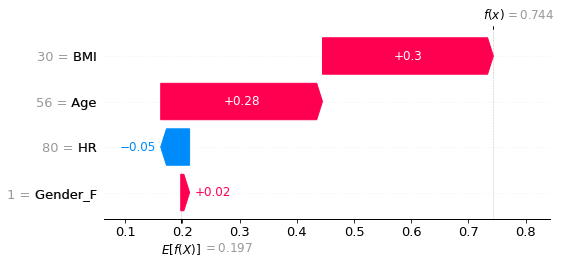

In [125]:
shap.plots.waterfall(shap_values[0], max_display=20)

Vemos que aqui los resultados nos salen diferentes, pero es normal, porque hemos generado muy pocas muestras aleatorias en el modelo, probablemente el paquete haya calculado más.

Aun así vemos que en ambos casos las variables que mas cuentan positivamente son BMI y Age. En ambos casos Gender_F tiene un valor cercano a 0 y en ambos casos HR tiene un valor negativos.

In [124]:
pd.DataFrame(shap_values.values, columns = df.iloc[:,0:4].columns)

,Age,Gender_F,BMI,HR
0,0.282800,0.015457,0.298739,-0.050494
1,0.617970,-0.015457,0.725508,-0.333262
2,0.282800,-0.015457,0.085354,-0.131285
3,-0.052370,0.015457,-0.128031,-0.010099
4,-0.366592,0.015457,0.128031,0.030297
5,0.366592,-0.015457,-0.128031,-0.030297
6,-0.094267,0.015457,0.170708,-0.058573


Aqui vemos el SHAP value de cada variable para cada muestra